# DWT 2BPRFB
- Keras model
- Lv 2


---
Kishore Kr. Tarafdar --@k, 25/09/2022

<br />
<br />

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

2022-09-27 03:14:08.757300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 03:14:08.757341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import import_ipynb
from DWTLayer1D1Ch import AnalysisBranch1D
from IDWTLayer1D1Ch import SynthesisBranch1D
from AddSynthesisBranchOutputs import Add1D
from ImpulseRespones2BPRFB import ImpulseRespones2BPRFB

importing Jupyter notebook from DWTLayer1D1Ch.ipynb
importing Jupyter notebook from IDWTLayer1D1Ch.ipynb
importing Jupyter notebook from AddSynthesisBranchOutputs.ipynb
importing Jupyter notebook from ImpulseRespones2BPRFB.ipynb


In [3]:
%precision %.4f

'%.4f'

<br />


Reconstruction error, $\epsilon=\frac{1}{N}\sum_{k}\mid\frac{x_{k}-\hat{x}_{k}}{x_{k}}\mid$

In [4]:
err = lambda xn, xn_hat:np.round(np.sum(abs((xn-xn_hat.T)[0]/xn))/len(xn) * 100,5)

<br />
<br />


---

**Initialize** conv. **kernel** using 2BPRFB Analysis LPF and HPF impulse response

In [5]:
mother_wavelet = 'coif1'  # <<----
global h0n, h1n, g0n, g1n

#from ImpulseRespones2BPRFB import ImpulseRespones2BPRFB
w = ImpulseRespones2BPRFB(mother_wavelet)
h0n, h1n = w.analysis()
g0n, g1n = w.synthesis()

filt_len = len(h0n)
#h0 = tf.keras.initializers.Constant(h0n)
#h1 = tf.keras.initializers.Constant(h1n)
del w

Impulse response (Analysis DT filt.):
 [-0.07273261951252645, 0.3378976624574818, 0.8525720202116004, 0.3848648468648578, -0.07273261951252645, -0.015655728135791993]
 [-0.015655728135791993, 0.07273261951252645, 0.3848648468648578, -0.8525720202116004, 0.3378976624574818, 0.07273261951252645],

Impulse response (Synthesis DT filt.):
 [-0.015655728135791993, -0.07273261951252645, 0.3848648468648578, 0.8525720202116004, 0.3378976624574818, -0.07273261951252645]
 [0.07273261951252645, 0.3378976624574818, -0.8525720202116004, 0.3848648468648578, 0.07273261951252645, -0.015655728135791993],



<br />
<br />

**DWT 2BPRFB Lv.1 keras model**

In [6]:
def dwt_2BPRFB(input_shape:tuple):
    """DWT 2BPRFB --@k 01/09/2022"""
    
    global h0n, h1n, g0n, g1n

    #input_shape = 224,1
    inputs = Input(input_shape)
    
    ##Analysis FB
    Ψ1 = AnalysisBranch1D(h1n)(inputs)
    ϕ1 = AnalysisBranch1D(h0n)(inputs)
    
    Ψ2 = AnalysisBranch1D(h1n)(ϕ1)
    ϕ2 = AnalysisBranch1D(h0n)(ϕ1)
    """
    __._____ Ψ1 _____.__
      |__.__ Ψ2 __.__+
         |__ ϕ2 __+
        
    """
    ##Synthesis FB
    ϕ2_up_filt = SynthesisBranch1D(g0n)(ϕ2)
    Ψ2_up_filt = SynthesisBranch1D(g1n)(Ψ2)
    sum1 = Add1D(g0n)([ϕ2_up_filt, Ψ2_up_filt])
    
    sum1_up_filt = SynthesisBranch1D(g0n)(sum1)#_pad_removed)
    Ψ1_up_filt = SynthesisBranch1D(g1n)(Ψ1)
    output = Add1D(g0n)([sum1_up_filt,Ψ1_up_filt])
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model 

<br />
<br />
<br />
<br />

---

In [7]:
input_shape = 1024,1
model = dwt_2BPRFB(input_shape)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2022-09-27 03:14:12.768374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-27 03:14:12.768409: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-27 03:14:12.768434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (L3460): /proc/driver/nvidia/version does not exist
2022-09-27 03:14:12.768722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


518 <class 'int'> ups+
(518, 1) (None, 518, 1)
(None, 518, 1) <
518 <class 'int'> ups+
(518, 1) (None, 518, 1)
(None, 518, 1) <
1028 <class 'int'> ups+
(1028, 1) (None, 1028, 1)
(None, 1028, 1) <
1028 <class 'int'> ups+
(1028, 1) (None, 1028, 1)
(None, 1028, 1) <
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 analysis_branch1d_1 (AnalysisB  (None, 514, 1)      7           ['input_1[0][0]']                
 ranch1D)                                                                                         
                                                                                                  
 analysis_branch1d_3 (Analys

<br />
<br />
<br />
<br />
<br />
<br />

---
TEST PASS

$B=1$ : 

---
<br />

Let, $x[n]=$

In [8]:
# SAMPLE INPUT
#x = [1,2,3,4,5,6]
B = 1
import numpy as np
xn = np.random.rand(input_shape[0])
xn.shape

(1024,)

Rank 3 input tensor, $p \leftarrow x[n]$

In [9]:
p = tf.constant(xn, dtype=tf.float32, name='x')
p.shape[0]
p = tf.reshape(p, [B,int(p.shape[0]), 1])
###p = tf.dtypes.cast(p, tf.float32)
p.shape

TensorShape([1, 1024, 1])

In [10]:
p_hat = model.predict(p)
p_hat.shape

518 <class 'int'> ups+
(518, 1) (None, 518, 1)
(None, 518, 1) <
518 <class 'int'> ups+
(518, 1) (None, 518, 1)
(None, 518, 1) <
1028 <class 'int'> ups+
(1028, 1) (None, 1028, 1)
(None, 1028, 1) <
1028 <class 'int'> ups+
(1028, 1) (None, 1028, 1)
(None, 1028, 1) <


(1, 1024, 1)

In [11]:
p_hat[0,:,:].shape

(1024, 1)

In [12]:
xn_hat = p_hat[0,:,:]

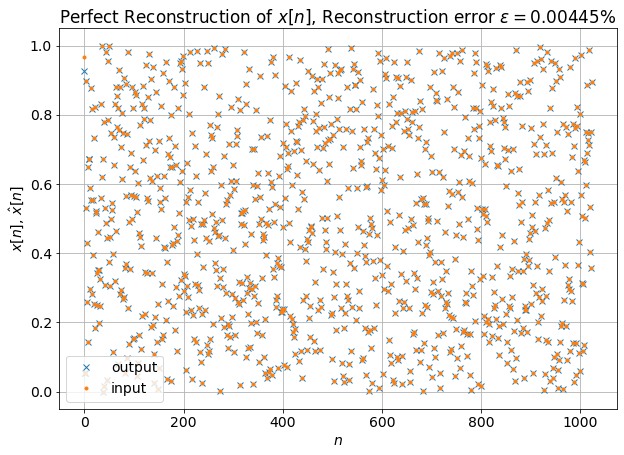

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(xn_hat,'x',label='output')
plt.plot(xn,'.',label='input')
plt.legend()
plt.grid()
plt.title(f'Perfect Reconstruction of $x[n]$, \
Reconstruction error $\epsilon =${err(xn,p_hat[0,:,:])}%')
plt.xlabel('$n$')
plt.ylabel('$x[n]$, $\hatx[n]$')
plt.show()

<br />
<br />
<br />
<br />
<br />
<br />

---
TEST PASS

$B=multiple$ : 

---
<br />

Let, $x[n]=$

In [14]:
# SAMPLE INPUT
B = 5
xn = np.random.rand(B,input_shape[0])
xn.shape

(5, 1024)

<br />
Rank 3 input tensor, $p \leftarrow x[n]$

In [15]:
p = tf.constant(xn, dtype=tf.float32, name='x')
p.shape[0]
p = tf.reshape(p, [B,int(p.shape[1]), 1])
###p = tf.dtypes.cast(p, tf.float32)
p.shape

TensorShape([5, 1024, 1])

In [16]:
p_hat = model.predict(p)
p_hat.shape

(5, 1024, 1)

In [17]:
p_hat[0,:,:].shape

(1024, 1)

In [18]:
xn.shape

(5, 1024)

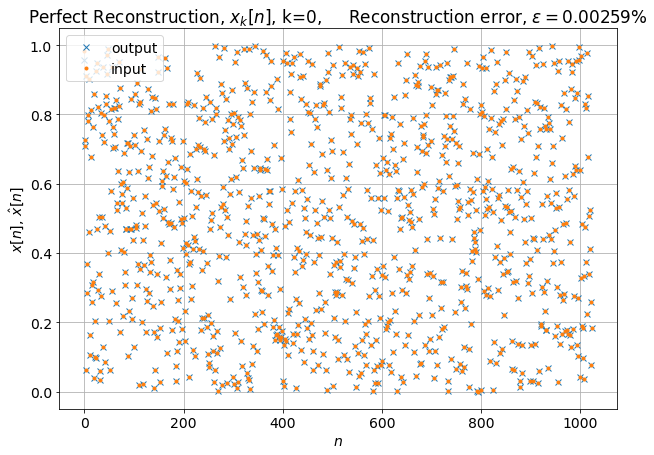

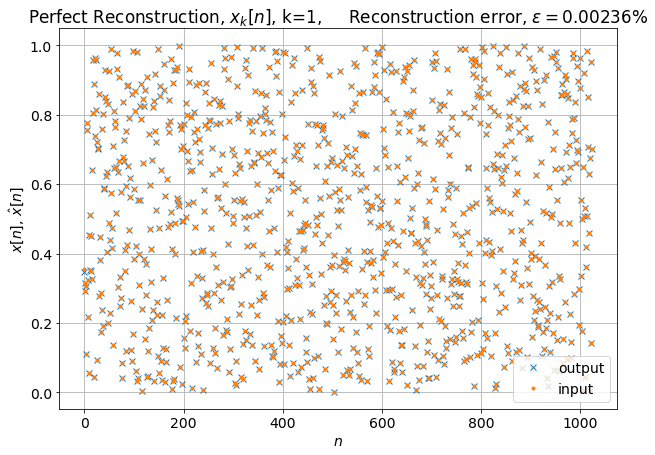

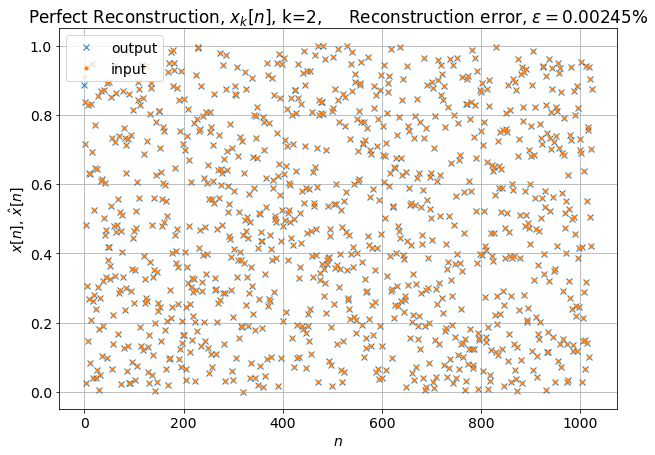

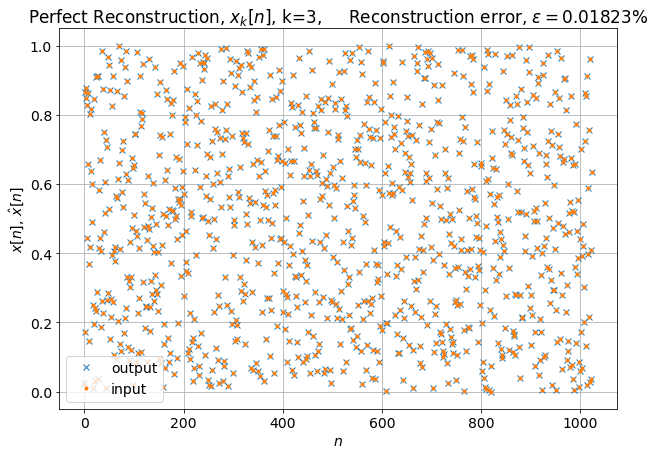

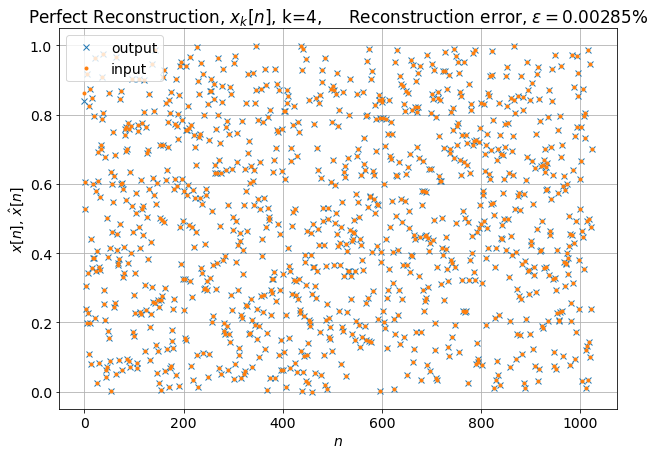

In [19]:
import matplotlib.pyplot as plt
for k in range(B):
    plt.figure(figsize=(10,7))
    plt.plot(p_hat[k,:,:],'x',label='output')
    plt.plot(xn[k,:],'.',label='input')
    plt.legend()
    plt.grid()
    plt.title(f'Perfect Reconstruction, $x_k[n]$, k={k}, \
    Reconstruction error, $\epsilon=${err(xn[k,:],p_hat[k,:,:])}%')
    plt.xlabel('$n$')
    plt.ylabel('$x[n]$, $\hatx[n]$')
    plt.show()

<br />
<br />

---